In [1]:
from pythonlib.tools.stroketools import *
from tools.preprocess import *
from sklearn.linear_model import LinearRegression
from pyvm.classes.videoclass import Videos
from tools.handtrack import HandTrack, getTrialsCameraFrametimes
from pyvm.utils.directories import get_metadata
from pythonlib.tools.expttools import load_yaml_config
from pyvm.globals import BASEDIR
import pyvm.run.dlc_xyz_extraction as extract
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

In [17]:
name = "221015_dircolor1"
date = "221015"
expt = "dircolor1"
sess = 1
sess_print = ""
animal = "Pancho"
ind1_ml2 = 1
pipe_path = "/home/danhan/Documents/pipeline"
data_dir = "/data3/hand_track"
condition = "behavior"
path = "/home/danhan/Documents/pipeline/dlt_coeffs/no_axis_opt"
trial = 101
cam_list = ["fly2", "fly1","flea","bfs1"]

In [18]:
config = load_yaml_config(f"{pipe_path}/metadata/{name}.yaml")
vid_inds = config["list_vidnums"][0]
trange = range(vid_inds[0],vid_inds[1])
# ind1_vid = vid_inds[0]
ind1_vid = 0
# print(ind1_vid)
# assert False
print("Vid", trange)

fd = loadSingleDataQuick(animal, date, expt, sess)
HT = HandTrack(ind1_vid, ind1_ml2, fd, date=date, expt=expt)
HT.load_campy_data(ind1_ml2, sess=sess_print)
trials_no_ts_data = []

Vid range(98, 101)
/home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/221015/221015_*_dircolor1_Pancho_1.pkl
/home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/221015/221015_*_dircolor1_Pancho_1.pkl
-- loaded presaved data: /home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/221015/221015_140751_dircolor1_Pancho_1.pkl


In [25]:
dat, _, _ = HT.process_data_singletrial(99, ploton=False, finger_raise_time=0.0)
print(dat)

TODO: Get accurate frametime after pass in frame extraction to Buttons
Searching using this string:
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/*camera*trial_98-*dat**
Found this many paths:
4
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_bfs1_-trial_98-dat.pkl
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_flea_-trial_98-dat.pkl
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_fly1_-trial_98-dat.pkl
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_fly2_-trial_98-dat.pkl
{}


In [19]:
#Extract hadn track time data for strokes
dat, _, _ = HT.process_data_singletrial(trial, ploton=False, finger_raise_time=0.0)

strokes_cam_all = []
strokes_cam_allz = []
strokes_touch_all = []
touch_interpz = []

for strok_cam, strok_touch in zip(dat["strokes_cam"], dat["strokes_touch"]):
    strokes_cam_allz.append(np.array(strok_cam))
    strokes_touch_all.append(np.array(strok_touch))

assert (strokes_touch_all != {}), "No data for this expt"

times = np.array([])
N = ["input_times"]
for strok in strokes_cam_allz:
    N.append(np.array([p[3] for p in strok]))
    times = np.concatenate((times,np.array([p[3] for p in strok])))


TODO: Get accurate frametime after pass in frame extraction to Buttons
Searching using this string:
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/*camera*trial_100-*dat**
Found this many paths:
4
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_bfs1_-trial_100-dat.pkl
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_flea_-trial_100-dat.pkl
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_fly1_-trial_100-dat.pkl
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_fly2_-trial_100-dat.pkl


KeyError: 'strokes_cam'

/tmp/ipykernel_30460/2279505796.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(raw_df[f"{cam}_x"], raw_df[f"{cam}_y"], c=colors, cmap='viridis', label=cam)


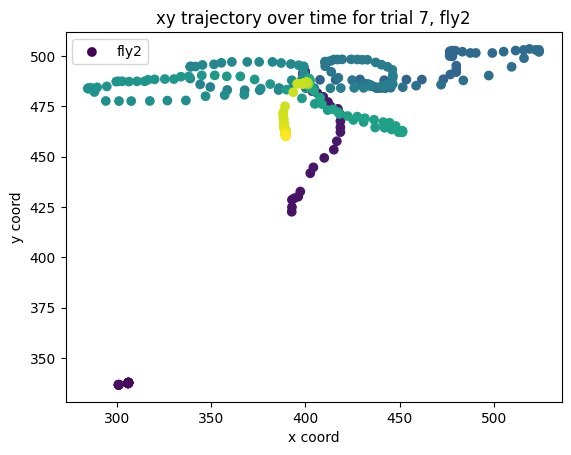

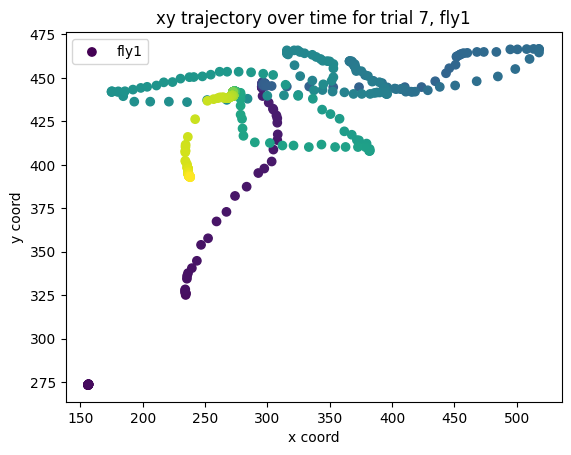

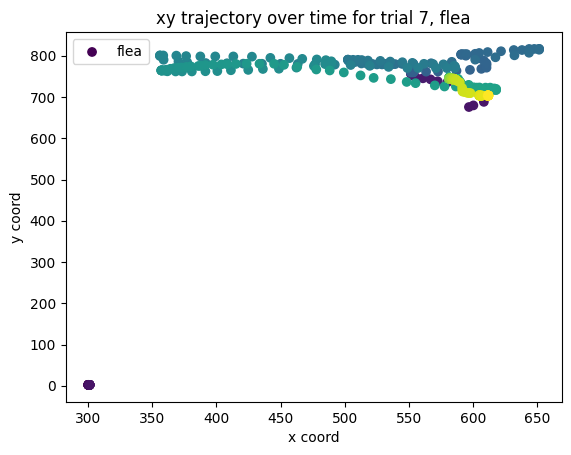

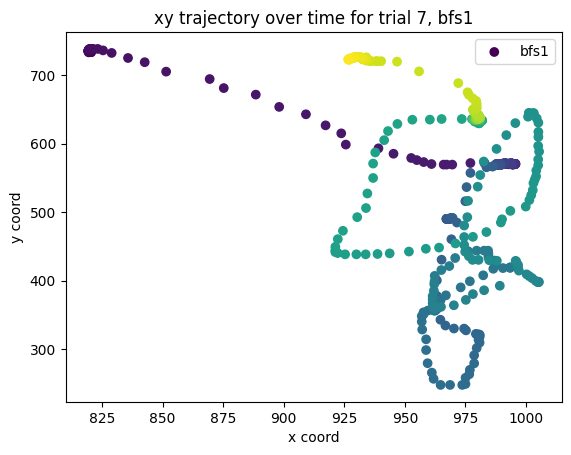

In [86]:
#Step 1 
# Raw dlc data in xy format, not really useful but done for thoroughness
dlc_data_dir = f"{data_dir}/{animal}/{name}/behavior/extracted_dlc_data/"
trans_dlc_pts = np.load(f"{dlc_data_dir}/3d-part_fingertip-trial_7-dat.npy")
dlc_cols = ["fly2_x","fly2_y","fly1_x","fly1_y","flea_x","flea_y","bfs1_x","bfs1_y"]

raw_df = pd.DataFrame(columns=dlc_cols)
for cam in cam_list:
    with open(f"{dlc_data_dir}/camera_{cam}_-trial_7-dat.pkl",'rb') as f:
        data = pd.DataFrame(pickle.load(f))
        data=data.droplevel(level=[0,1], axis=1)
        raw_df[f"{cam}_x"] = data["x"]
        raw_df[f"{cam}_y"] = data["y"]
for i,cam in enumerate(cam_list):
        n_points = len(raw_df)
        indices=np.arange(n_points)
        colors = plt.cm.viridis(indices/max(indices))
        plt.scatter(raw_df[f"{cam}_x"], raw_df[f"{cam}_y"], c=colors, cmap='viridis', label=cam)
        plt.xlabel('x coord')
        plt.ylabel('y coord')
        plt.title(f'xy trajectory over time for trial {trial-1}, {cam}')
        plt.legend()
        plt.show()



In [1]:
#Step 2 
#DLC data transformed into 3d using dlt coefs, first transformation that is run
dfall, t, pts, camdict = HT.get_trials_all_data(trial, filter_by_likeli_thresh=True)
dfall_1 = dfall.copy()
dfall_conv = HT.convert_coords(dfall)
# pts_time_cam_all = dfall[["x", "y", "z", "t_trial"]].values # all times, not just those in ml2 strokes

# get strokes from onset to touch done
# strokes = getTrialsStrokesByPeanuts(fd, trial_ml2)
# strokes = getTrialsStrokesClean(fd, trial_ml2)
df_list = []
strokes = getTrialsStrokes(fd, trial, window_rel_go_reward = [-0.1, 0.1])
strokes_task = getTrialsTaskAsStrokes(fd, trial)

fig, axes = plt.subplots(1,3,figsize=(30,10))
for i,strok in enumerate(strokes):
    strok_df = pd.DataFrame(strok)
    df_list.append(strok_df)
    axes[0].scatter(strok_df[0], strok_df[1], label=f"ts {i}" )
    axes[0].legend()

for i,df in enumerate(df_list):
    strok_df = dfall[dfall["t_trial"].isin(df[2])]
    axes[1].scatter(strok_df[f"y"], strok_df[f"x"], label=i, marker='x')
    axes[1].set_xlabel('x coord')
    axes[1].set_ylabel('y coord')
    axes[1].set_title(f'xy trajectory over time for trial {trial-1}')
    axes[1].legend()

for i,df in enumerate(df_list):
    strok_df = dfall_1[dfall_1["t_trial"].isin(df[2])]
    axes[2].scatter(-strok_df[f"y"], -strok_df[f"x"], label=i, marker='x')
    axes[2].set_xlabel('x coord')
    axes[2].set_ylabel('y coord')
    axes[2].set_title(f'xy trajectory over time for trial {trial-1}')
    axes[2].legend()


NameError: name 'HT' is not defined

In [169]:
def convert_pix_to_meters(pts):
    """ 
    PARAMS:
    - pts, assumes all columns are pixels (i..e, removed last time oclumn)
    RETURNS:
    - copy of pts, in meters
    """
    pts = pts.copy()
    conv = HT.coordinate_conversion()
    return pts/conv["pix_over_m"]

def snap_pts_to_strokes(strokes_template, pts_to_snap, finger_raise_time=0.0):
    """
    takes datapoints in pts_to_snap, and generates strokes version of this, 
    based on relatiing its timettamps to those fo strokes_template. Assumes
    that pts_to_snap can yield both sstrokes and gaps. 
    PARAMS:
    - strokes_template, strokes type, this determines the onsets and offsets of
    strokes (that's all)
    - pts_to_snap, NxD, where D usually 3 (x,y,t) or 4 (x,y,z,t). 
    - finger_raise_time = 0.1 # num seconds allow for raising and lowering. will ignore this much of the time flanking
    # strokes, for defining what is a gap.
    RETURNS:
    - DAT, dict holding variations of strokes formatted pts_to_snap
    NOTES:
    - assumes that the last column is time. will use this to do snapping
    - naming reflects that wrote this for cam data.
    """
    from scipy.interpolate import interp1d
    
    DAT ={}
    
    # --- Which are dimensions of time?
    dim_t_1 = strokes_template[0].shape[1]-1
    dim_t_2 = pts_to_snap.shape[1]-1
    
    # Interpolate video to match touchscreen times
    t = pts_to_snap[:,dim_t_2]
    pts = pts_to_snap[:,:dim_t_2]
    funcinterp = interp1d(t, pts, axis=0)
    
    # create strokes_cam, using original cam pts, taking within bounds of strokes.
    strokes_cam = []
    strokes_cam_interp = []
    gaps_cam = [] # same format as strokes..
    t0 = 0.
    for i, strok in enumerate(strokes_template):
        
        # find all cam pts within bounds of the times of this ml2 stroke
        t1 = strok[0,dim_t_1]
        t2 = strok[-1,dim_t_1]
        tall = strok[:,dim_t_1]
        
        # - strokes
        inds = (pts_to_snap[:,dim_t_2]>=t1) & (pts_to_snap[:,dim_t_2]<=t2)
        strokes_cam.append(pts_to_snap[inds, :])
    
        # - strokes, but interpolate to use same timestamps
        if np.any((tall<=t[0]) | (tall>=t[-1])):
            assert False, "fix the underying issue."
        tall = tall[(tall>=t[0]) & (tall<=t[-1])] # cannot extrapolate.
        strokes_cam_interp.append(funcinterp(tall))
        
        # - gaps (the one preceding this stroke)
        inds = (pts_to_snap[:,dim_t_2]>t0+finger_raise_time) & (pts_to_snap[:,dim_t_2]<t1-finger_raise_time)
        gaps_cam.append(pts_to_snap[inds, :])
        
        # if this is the last stroke, then the rest of data is a long gap
        if i==len(strokes_template)-1:
            inds = (pts_to_snap[:,dim_t_2]>t2+finger_raise_time)
            gaps_cam.append(pts_to_snap[inds, :])
        
        # - update t0 for next gap
        t0 = t2
    
    # remove empty things
    strokes_cam = [s for s in strokes_cam if len(s)>0]
    gaps_cam = [s for s in gaps_cam if len(s)>0]        
    
    # get flatteend versions
    pts_cam_interp = np.concatenate(strokes_cam_interp)
    
    DAT["pts_cam_interp"] = pts_cam_interp
    DAT["strokes_cam_interp"] = strokes_cam_interp
    DAT["strokes_cam"] = strokes_cam
    DAT["gaps_cam"] = gaps_cam
    DAT["pts_time_cam_all"] = pts_to_snap
    DAT["strokes_touch"] = strokes_template
    
    return DAT

In [174]:
dfall = HT.convert_coords(dfall)
pts_time_cam_all = dfall[["x", "y", "z", "t_trial"]].values # all times, not just those in ml2 strokes

# get strokes from onset to touch done
# strokes = getTrialsStrokesByPeanuts(fd, trial_ml2)
# strokes = getTrialsStrokesClean(fd, trial_ml2)
strokes = getTrialsStrokes(fd, trial, window_rel_go_reward = [-0.1, 0.1])
strokes_task = getTrialsTaskAsStrokes(fd, trial)



pts_time_cam_all = pts_time_cam_all.copy()
pts_time_cam_all[:, :3] = convert_pix_to_meters(pts_time_cam_all[:, :3])
strokes_meters = []
for strok in strokes:
    x = strok.copy()
    x[:, :2] = convert_pix_to_meters(x[:,:2])
    strokes_meters.append(x)
strokes = strokes_meters

strokes_meters = []
for strok in strokes_task:
    x = strok.copy()
    x[:, :2] = convert_pix_to_meters(x[:,:2])
    strokes_meters.append(x)
    strokes_task = strokes_meters

dat = snap_pts_to_strokes(strokes, pts_time_cam_all)
print(dat)

500.0
{'pts_cam_interp': array([[ 3.27530180e+34,  3.81299070e+33, -2.27444233e+34],
       [ 3.27535791e+34,  3.81337610e+33, -2.27446237e+34],
       [ 3.27541402e+34,  3.81376150e+33, -2.27448242e+34],
       ...,
       [ 2.84243919e+34,  7.46590598e+33, -2.11504213e+34],
       [ 2.84240882e+34,  7.46702507e+33, -2.11498347e+34],
       [ 2.84237845e+34,  7.46814415e+33, -2.11492482e+34]]), 'strokes_cam_interp': [array([[ 3.27530180e+34,  3.81299070e+33, -2.27444233e+34],
       [ 3.27535791e+34,  3.81337610e+33, -2.27446237e+34],
       [ 3.27541402e+34,  3.81376150e+33, -2.27448242e+34],
       [ 3.27547013e+34,  3.81414691e+33, -2.27450247e+34],
       [ 3.27552623e+34,  3.81453231e+33, -2.27452251e+34],
       [ 3.27558234e+34,  3.81491771e+33, -2.27454256e+34],
       [ 3.27563845e+34,  3.81530312e+33, -2.27456260e+34],
       [ 3.27569456e+34,  3.81568852e+33, -2.27458265e+34],
       [ 3.27575067e+34,  3.81607392e+33, -2.27460270e+34],
       [ 3.27580678e+34,  3.81645932e+